In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [12]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [13]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [15]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [16]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [90]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      if x.ndim ==3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    # self.out = None

  def __call__(self, ix):
    self.out = self.weight[ix]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  """ flattent the first last two dimensions of the tensor based on n"""
  def __init__(self, n):
    self.n = n

  def __call__(self, x): # x --> embedding
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n) # flatten the last two dimensions
    if T//self.n == 1:
      x = x.squeeze(1)
    # self.out = x.view(x.shape[0], -1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  

In [18]:
torch.manual_seed(42); # seed rng for reproducibility

In [91]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP


# C = torch.randn((vocab_size, n_embd))
model = Sequential([
  Embedding(vocab_size, n_embd), # embedding layer
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [92]:
for layer in model.layers:
    print(layer.__class__.__name__, " : ", layer.out.shape)

AttributeError: 'Embedding' object has no attribute 'out'

In [93]:
e = torch.randn((6, 4, 8))
emean = e.mean(dim=(0,1), keepdim=True) # 1 4 68
evar = e.var(dim=(0,1), keepdim=True) # 1 4 68
e.shape, emean.shape, evar.shape

(torch.Size([6, 4, 8]), torch.Size([1, 1, 8]), torch.Size([1, 1, 8]))

In [94]:
evar

tensor([[[1.1902, 0.7937, 0.7010, 0.9162, 0.7899, 1.0799, 0.9394, 0.8833]]])

In [89]:
evar.expand_as(e)

tensor([[[1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697]],

        [[1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697]],

        [[1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697]],

        [[1.1649, 1.3560, 1.0942, 1.1587, 0.8850, 0.6581, 0.5946, 0.8697],
         [1.1649, 1

In [85]:
evar

tensor([[[0.5444, 0.2350, 0.4203, 0.5053, 0.5229, 1.3925, 0.6035, 0.7143],
         [2.0950, 1.6852, 1.3073, 0.7835, 0.4271, 0.6987, 0.6306, 0.2070],
         [1.2756, 0.6290, 1.6143, 0.4955, 1.0909, 0.8944, 1.3435, 1.6009],
         [0.2798, 2.2519, 1.1828, 1.8791, 0.3517, 0.5675, 0.9625, 1.2213]]])

In [86]:
evar.expand_as(e)

tensor([[[0.5444, 0.2350, 0.4203, 0.5053, 0.5229, 1.3925, 0.6035, 0.7143],
         [2.0950, 1.6852, 1.3073, 0.7835, 0.4271, 0.6987, 0.6306, 0.2070],
         [1.2756, 0.6290, 1.6143, 0.4955, 1.0909, 0.8944, 1.3435, 1.6009],
         [0.2798, 2.2519, 1.1828, 1.8791, 0.3517, 0.5675, 0.9625, 1.2213]],

        [[0.5444, 0.2350, 0.4203, 0.5053, 0.5229, 1.3925, 0.6035, 0.7143],
         [2.0950, 1.6852, 1.3073, 0.7835, 0.4271, 0.6987, 0.6306, 0.2070],
         [1.2756, 0.6290, 1.6143, 0.4955, 1.0909, 0.8944, 1.3435, 1.6009],
         [0.2798, 2.2519, 1.1828, 1.8791, 0.3517, 0.5675, 0.9625, 1.2213]],

        [[0.5444, 0.2350, 0.4203, 0.5053, 0.5229, 1.3925, 0.6035, 0.7143],
         [2.0950, 1.6852, 1.3073, 0.7835, 0.4271, 0.6987, 0.6306, 0.2070],
         [1.2756, 0.6290, 1.6143, 0.4955, 1.0909, 0.8944, 1.3435, 1.6009],
         [0.2798, 2.2519, 1.1828, 1.8791, 0.3517, 0.5675, 0.9625, 1.2213]],

        [[0.5444, 0.2350, 0.4203, 0.5053, 0.5229, 1.3925, 0.6035, 0.7143],
         [2.0950, 1

In [67]:
bn = e - emean / ((evar))
bn.shape

torch.Size([4, 8])

In [69]:
e - emean == e- emean.expand_as(e)

tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]])

In [96]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # random batch of indices
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb) # logits
    # for layer in layers:
    #     x = layer(x)
    loss = F.cross_entropy(logits, Yb) # cross-entropy loss

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break 

      0/ 200000: 2.0330


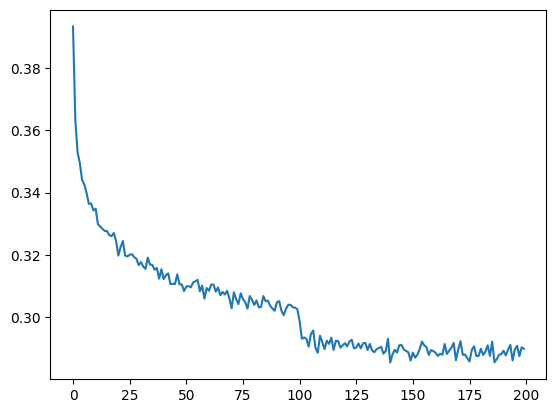

In [37]:
#using view we can make it 2d 
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [38]:
for layer in model.layers:
    layer.training = False # turn off training mode because batchnorm is in training mode

In [39]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9229532480239868
val 2.0222384929656982


In [40]:
for _ in range(20):

    op = []
    context = [0] * block_size
    while True:
        
        logits =  model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix] 
        op.append(ix)
        if ix == 0:
            break
    
    print("".join(itos[i] for i in op))

leleza.
leon.
luisara.
jabely.
jurhia.
cambree.
rirah.
allery.
mehce.
naset.
eliyah.
brodiow.
ayani.
kartheli.
treviyah.
failan.
zhole.
darelynn.
eamari.
kallie.
